<a href="https://colab.research.google.com/github/pratishthaa/LeanIn_July2021_NLP_Pratishtha/blob/main/Tweet_Act_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TWEET ACT CLASSIFICATION**

---



---



Problem Statement : Tweet Act Classification helps in comprehending the communicative intention of a tweeter. The main objective of this particular task is to identify speech acts in Twitter, i.e., tweet act classification. Given a tweet X, the task is to assign the most appropriate tweet act (say y2 among a set of tags (Y = {y1, y2, ... yi} where i is the number of tweet acts). Thus, it is a multi-class classification problem. Formally, it can be represented as y = argmax_{y'∈ Y} F(y'|X) where F is the developed tweet act classifier.

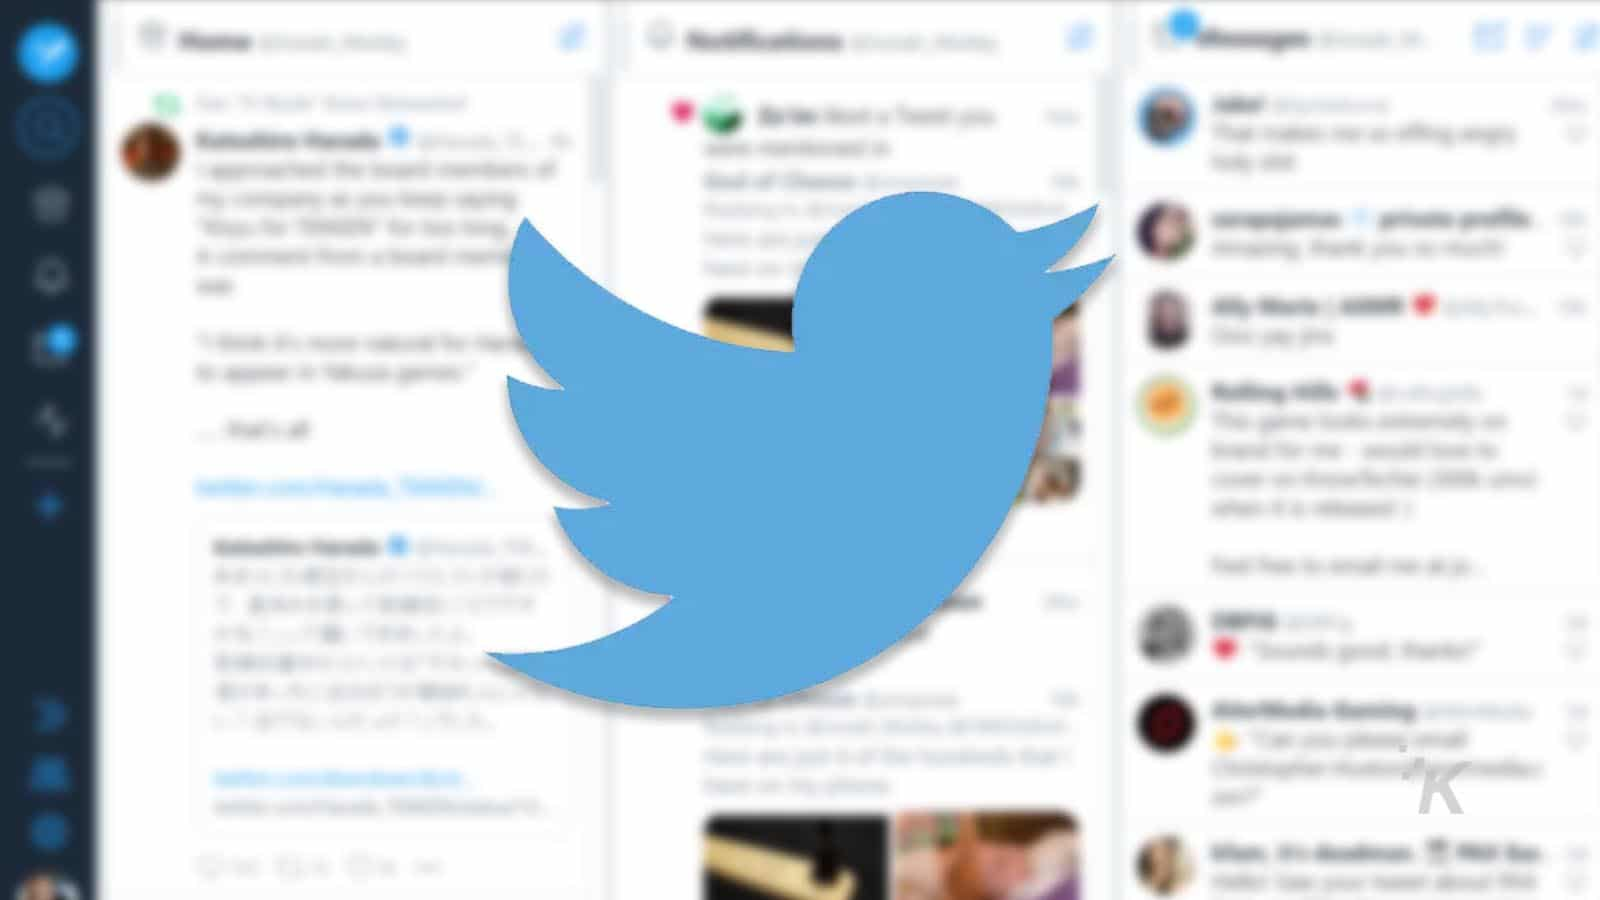

In [360]:
!wget https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt


--2021-09-01 01:50:36--  https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53933315 (51M) [text/plain]
Saving to: ‘glove.840B.300d.sst.txt’

glove.840B.300d.sst 100%[===================>]  51.43M   190MB/s    in 0.3s    

2021-09-01 01:50:36 (190 MB/s) - ‘glove.840B.300d.sst.txt’ saved [53933315/53933315]



In [361]:
!cp glove.840B.300d.sst.txt sample_data/glove.840B.300d.sst.txt

### **IMPORT REQUIRED LIBRARIES AND MODULES**

In [362]:
import pandas as pd
import numpy as np
import os
import pickle
import numpy as np
import re
import itertools
from collections import Counter

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from numpy import array
from keras.models import Sequential
from keras.layers import *

from keras.preprocessing import sequence
from keras.regularizers import *
import tensorflow as tf
from keras.preprocessing.text import *
from keras.preprocessing.sequence import pad_sequences
import timeit

## **LOAD NECESSARY FUNCTIONS**


In [363]:
def dumpPickle(path,object_to_dump):
	f=open(path,'wb')
	pickle.dump(object_to_dump,f)
	f.close()

#Reads an object stores at 'path'
def readPickle(path):
	f=open(path,'rb')
	ob_to_load=pickle.load(f)
	f.close()
	return ob_to_load

def load_create_embedding_matrix(word_index,vocab_size,emb_dim,emb_path,emb_pickle_path=False,save=False,saveName=None):
	if not emb_pickle_path:
		embedding_dict={}
		f=open(emb_path,'rb')
		for line in f:
			fields=line.split()
			word=fields[0]
			w_e=np.asarray(fields[1:],dtype='float32')
			embedding_dict[word]=w_e
		f.close()
		allembs=np.stack(embedding_dict.values())
		emb_mean,emb_std=allembs.mean(),allembs.std()
		embedding_matrix=np.random.normal(emb_mean,emb_std,(vocab_size,emb_dim))
		for word,index in word_index.items():
		
			vector=embedding_dict.get(word)
			if vector is not None:
				embedding_matrix[index]=vector
		if save:
			dumpPickle(saveName,embedding_matrix)
	else:
		f=open(emb_pickle_path,'rb')
		embedding_matrix=pickle.load(f)
		f.close()
	return embedding_matrix
  
def load_create_tokenizer(train_data,tok_path=None,savetokenizer=False):
	if tok_path == None:
		tokenizer=Tokenizer()
		tokenizer.fit_on_texts(train_data)
		len(tokenizer.word_index)
		if savetokenizer:
			dumpPickle('./New_Tokenizer.tkn',tokenizer)
	else:
		tokenizer=readPickle(tok_path)
	return tokenizer

def load_create_padded_data(X_train,savetokenizer,padPath=None,isPaddingDone=False,maxlen=None,tokenizer_path=None,save_new_padded_data=False,path_for_new_data=False):
	
	if not isPaddingDone:
		tokenizer=load_create_tokenizer(X_train,tok_path=tokenizer_path,savetokenizer=savetokenizer)
		
		X_train=tokenizer.texts_to_sequences(X_train)
		X_train=pad_sequences(X_train,maxlen=maxlen)
		if save_new_padded_data:
			dumpPickle(path_for_new_data,X_train)
	else:
		X_train=readPickle(padPath)
	return X_train

### **LOADING DATASET**

In [364]:
df=pd.read_csv("/content/TWEET_DATA_IEEE_TCSS_-_Sheet1.csv",names=["tweets","labels"])
df.head()

,tweets,labels
0,RT @Bipartisanism: Katie Couric just schooled ...,STM
1,RT @stevesilberman: If you missed it: Sick bur...,EXP
2,@jk_rowling & the Never-Ending Story: With a #...,QUE
3,RT @somebadideas: The emotional & personal eff...,EXP
4,RT @jk_rowling: A 9-year-old Nigerian girl has...,STM


SOME TEXT CLEANING IS REQUIRED AS THE DATA IS TWEETS

In [365]:
df['tweets']=df['tweets'].str.lower()
df['tweets'] = df['tweets'].str.replace('\d+', '')
df['tweets'] = df['tweets'].str.replace('@\S+', '')
df['tweets'] = df['tweets'].str.replace('https*\S+', '')
df['tweets'] = df['tweets'].str.replace('#\S+', ' ')
df['tweets'] = df['tweets'].str.replace('[%s]' % re.escape(string.punctuation), '')
df['tweets'] = df['tweets'].str.replace('\s{2,}', '')
df['tweets'] = df['tweets'].str.replace('rt', '')


In [366]:
df.head()

,tweets,labels
0,katie couric just schooledon gay marriage in e...,STM
1,if you missed it sick burn,EXP
2,the neverending story with aahead are suppleme...,QUE
3,the emotionalpersonal effects of climate chang...,EXP
4,a yearold nigerian girl has written a book abo...,STM


In [367]:
df.drop("labels",axis=1,inplace=True)
df.head()

,tweets
0,katie couric just schooledon gay marriage in e...
1,if you missed it sick burn
2,the neverending story with aahead are suppleme...
3,the emotionalpersonal effects of climate chang...
4,a yearold nigerian girl has written a book abo...


TO STORES LABELS IN OTHER LIST, I HAVE CREATED OTHER DATAFRAME

In [368]:
dff=pd.read_csv("/content/TWEET_DATA_IEEE_TCSS_-_Sheet1.csv",names=["tweets","labels"])
dff.drop("tweets",axis=1,inplace=True)
dff.head()

,labels
0,STM
1,EXP
2,QUE
3,EXP
4,STM


In [369]:
text = df['tweets'].tolist()

In [370]:
print(text)

['katie couric just schooledon gay marriage in epic fashion ', 'if you missed it sick burn ', 'the neverending story with aahead are supplementary stories still', 'the emotionalpersonal effects of climate change on the scientists studying it a fascinating must read ', 'a yearold nigerian girl has written a book about the effects of terrorism on children', 'i dont want to say too much more because i dont want to spoil what i know will be a real treat for fans', ' read the casual vacancy was hesitant at first but its a masterpiece well done influenced my childhood and now adulthood', 'first they came for the content producers and i did not speak up because of this one weird trick that will shock you', ' did you base voldemo on idsis iain duncan smith visibly excited by prospect of huing the poor ', ' i have a question about harry when voldemo kills the horcux that was inside of harry does harry still speak parseltongue', ' does harry see the grim in histeacup in prisoner of azkaban just 

In [371]:
max1=0

for i in range(0,len(text)):
	data=text[i].split(" ")
	max2=len(data)
	if(max2>max1):
		max1=max2

sequence_length = max1

In [372]:
train, test = train_test_split(text, test_size = 0.2)

## **CREATE PADDED DATA & EMBEDDING MATRIX**


In [373]:
print("creating data")


tokenizer=load_create_tokenizer(train,None,True)
X_train=load_create_padded_data(X_train=train,savetokenizer=False,isPaddingDone=False,maxlen=sequence_length,tokenizer_path='./New_Tokenizer.tkn')
X_test=load_create_padded_data(X_train=test,savetokenizer=False,isPaddingDone=False,maxlen=sequence_length,tokenizer_path='./New_Tokenizer.tkn')
word_index=tokenizer.word_index
embedding_matrix=load_create_embedding_matrix(word_index,len(word_index)+1,300,'./glove.840B.300d.sst.txt',False,True,'./Emb_Mat.mat')

print("data created")

creating data


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


data created


In [374]:
len(word_index)

10971

In [375]:
X_train.shape

(6000, 57)

In [376]:
X_test.shape

(1500, 57)

In [377]:
X_train[125]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    5,    3, 1467,   17, 2464,    1,
       2465,   37,   87,    5,    3, 2466, 1134,   17, 1969,  187,   47,
        156,  656], dtype=int32)

In [378]:
embedding_matrix.shape

(10972, 300)

In [379]:
label_list = dff['labels'].tolist()

In [380]:
print(label_list)

['STM', 'EXP', 'QUE', 'EXP', 'STM', 'EXP', 'EXP', 'EXP', 'QUE', 'QUE', 'QUE', 'QUE', 'EXP', 'EXP', 'EXP', 'OTH', 'STM', 'EXP', 'STM', 'EXP', 'SUG', 'QUE', 'QUE', 'STM', 'REQ', 'STM', 'EXP', 'EXP', 'QUE', 'EXP', 'EXP', 'QUE', 'EXP', 'STM', 'EXP', 'STM', 'EXP', 'QUE', 'EXP', 'EXP', 'QUE', 'QUE', 'EXP', 'EXP', 'QUE', 'QUE', 'REQ', 'QUE', 'QUE', 'STM', 'REQ', 'EXP', 'QUE', 'EXP', 'OTH', 'EXP', 'QUE', 'STM', 'EXP', 'EXP', 'STM', 'QUE', 'EXP', 'EXP', 'EXP', 'STM', 'EXP', 'QUE', 'EXP', 'STM', 'QUE', 'EXP', 'QUE', 'EXP', 'QUE', 'OTH', 'EXP', 'OTH', 'REQ', 'EXP', 'EXP', 'EXP', 'QUE', 'QUE', 'OTH', 'OTH', 'QUE', 'STM', 'STM', 'EXP', 'EXP', 'EXP', 'EXP', 'EXP', 'EXP', 'SUG', 'STM', 'REQ', 'REQ', 'STM', 'REQ', 'QUE', 'EXP', 'STM', 'STM', 'STM', 'SUG', 'QUE', 'QUE', 'EXP', 'QUE', 'EXP', 'QUE', 'EXP', 'EXP', 'THT', 'EXP', 'EXP', 'OTH', 'EXP', 'QUE', 'QUE', 'QUE', 'STM', 'QUE', 'STM', 'STM', 'EXP', 'EXP', 'STM', 'EXP', 'STM', 'STM', 'STM', 'EXP', 'STM', 'EXP', 'STM', 'STM', 'STM', 'QUE', 'OTH', 'QUE'

In [381]:
train_l, test_l = train_test_split(label_list, test_size = 0.2)

## **CREATE ONE-HOT ENCODED LABELS**

In [382]:
lbl_dict={}
index=0
for dial_lbls in train_l:
	if dial_lbls not in lbl_dict:
		lbl_dict[dial_lbls]=index
		index=index+1

print((lbl_dict))



def create_label(label):
	
    Y=[]
    for i in label:
    	xxx=np.zeros(len(lbl_dict))  
    	j=lbl_dict.get(i)
    	xxx[j]=1
    	Y.append(xxx)
    return Y

label = train_l
Y_train = create_label(label)

label = test_l
Y_test = create_label(label)

y_train=np.array([i for i in Y_train])
y_test=np.array([i for i in Y_test])

embedding_dim = 300

{'EXP': 0, 'STM': 1, 'QUE': 2, 'OTH': 3, 'THT': 4, 'REQ': 5, 'SUG': 6}


In [383]:
y_train.shape
#y_train[4821]

(6000, 7)

In [384]:
from tensorflow.keras.optimizers import Adam

## **CREATE MODEL(CNN)**

In [392]:
print("Creating Model...")
#input layer
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=len(word_index)+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=sequence_length)(inputs)
conv_0 = Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu')(embedding)
maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
dropout = Dropout(0.1)(maxpool_0)
conv_1 = Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu')(dropout)
maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
flatten = Flatten()(maxpool_1)
predictions = Dense(1000, activation='relu')(flatten)

predictions1 = Dense(len(lbl_dict), activation='softmax')(predictions)
adam = Adam(lr=0.01, decay=0.3)
model = Model(inputs=inputs, outputs=predictions1)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=4, batch_size=64, validation_data=(X_test, y_test))


predicted=model.predict(X_test)
#print("DONE")

Creating Model...
Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


94/94 [==============================] - 5s 48ms/step - loss: 1.5700 - accuracy: 0.5157 - val_loss: 1.4388 - val_accuracy: 0.5180
Epoch 2/4
94/94 [==============================] - 4s 46ms/step - loss: 1.4009 - accuracy: 0.5315 - val_loss: 1.4384 - val_accuracy: 0.5180
Epoch 3/4
94/94 [==============================] - 4s 46ms/step - loss: 1.3988 - accuracy: 0.5315 - val_loss: 1.4409 - val_accuracy: 0.5180
Epoch 4/4
94/94 [==============================] - 4s 47ms/step - loss: 1.3952 - accuracy: 0.5315 - val_loss: 1.4356 - val_accuracy: 0.5180


In [386]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 57)]              0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 57, 300)           3291600   
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 57, 64)            192064    
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 28, 64)            0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 28, 64)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 28, 32)            6176      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 14, 32)            0   

## **EVALUATE MODEL**

In [387]:
Y_predicted=[]
for i in predicted:
    pos=i.argmax()
    Y_predicted.append(pos)
    
    
    
Y_test=[]
for i in y_test:
    pos=i.argmax()
    Y_test.append(pos)
    
    
    
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print(accuracy_score(Y_test, Y_predicted))
print(classification_report(Y_test, Y_predicted,digits=4,))
print(confusion_matrix(Y_test, Y_predicted))

0.518
              precision    recall  f1-score   support

           0     0.5180    1.0000    0.6825       777
           1     0.0000    0.0000    0.0000       331
           2     0.0000    0.0000    0.0000       129
           3     0.0000    0.0000    0.0000        73
           4     0.0000    0.0000    0.0000        68
           5     0.0000    0.0000    0.0000        46
           6     0.0000    0.0000    0.0000        76

    accuracy                         0.5180      1500
   macro avg     0.0740    0.1429    0.0975      1500
weighted avg     0.2683    0.5180    0.3535      1500

[[777   0   0   0   0   0   0]
 [331   0   0   0   0   0   0]
 [129   0   0   0   0   0   0]
 [ 73   0   0   0   0   0   0]
 [ 68   0   0   0   0   0   0]
 [ 46   0   0   0   0   0   0]
 [ 76   0   0   0   0   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **MODEL-Bi-LSTM**

In [388]:
 from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional


In [389]:
 n_unique_words = 1000000 # cut texts after this number of words
 maxlen = 200
 batch_size = 72

In [397]:
 model = Sequential()
 model.add(Embedding(n_unique_words, 72, input_length=maxlen))
 model.add(Bidirectional(LSTM(72)))
 model.add(Dropout(0.5))
 model.add(Dense(7, activation='sigmoid'))
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [398]:
 history=model.fit(X_train, y_train,
           batch_size=batch_size,
           epochs=4,
           validation_data=(X_test, y_test))
 print(history.history['loss'])
 print(history.history['accuracy'])

Epoch 1/4
84/84 [==============================] - 37s 405ms/step - loss: 0.3801 - accuracy: 0.4985 - val_loss: 0.3189 - val_accuracy: 0.5180
Epoch 2/4
84/84 [==============================] - 33s 397ms/step - loss: 0.3216 - accuracy: 0.5297 - val_loss: 0.3196 - val_accuracy: 0.5180
Epoch 3/4
84/84 [==============================] - 33s 398ms/step - loss: 0.3180 - accuracy: 0.5310 - val_loss: 0.3187 - val_accuracy: 0.5180
Epoch 4/4
84/84 [==============================] - 34s 403ms/step - loss: 0.3118 - accuracy: 0.5318 - val_loss: 0.3205 - val_accuracy: 0.5180
[0.38005730509757996, 0.3216220736503601, 0.3179798424243927, 0.3117772936820984]
[0.4984999895095825, 0.5296666622161865, 0.531000018119812, 0.5318333506584167]


In [400]:
predicted=model.predict(X_test)


In [401]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 200, 72)           72000000  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 144)               83520     
_________________________________________________________________
dropout_24 (Dropout)         (None, 144)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 7)                 1015      
Total params: 72,084,535
Trainable params: 72,084,535
Non-trainable params: 0
_________________________________________________________________


In [402]:
Y_predicted=[]
for i in predicted:
    pos=i.argmax()
    Y_predicted.append(pos)
    
    
    
Y_test=[]
for i in y_test:
    pos=i.argmax()
    Y_test.append(pos)
    
    
    
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print(accuracy_score(Y_test, Y_predicted))
print(classification_report(Y_test, Y_predicted,digits=4,))
print(confusion_matrix(Y_test, Y_predicted))

0.518
              precision    recall  f1-score   support

           0     0.5180    1.0000    0.6825       777
           1     0.0000    0.0000    0.0000       331
           2     0.0000    0.0000    0.0000       129
           3     0.0000    0.0000    0.0000        73
           4     0.0000    0.0000    0.0000        68
           5     0.0000    0.0000    0.0000        46
           6     0.0000    0.0000    0.0000        76

    accuracy                         0.5180      1500
   macro avg     0.0740    0.1429    0.0975      1500
weighted avg     0.2683    0.5180    0.3535      1500

[[777   0   0   0   0   0   0]
 [331   0   0   0   0   0   0]
 [129   0   0   0   0   0   0]
 [ 73   0   0   0   0   0   0]
 [ 68   0   0   0   0   0   0]
 [ 46   0   0   0   0   0   0]
 [ 76   0   0   0   0   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
